In [8]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity

# --- Utilities ---
def extract_station_info(station_field: str):
    """Extract station code and name from the 'Estacion_Parada' column."""
    if not station_field or "(" not in station_field or ")" not in station_field:
        return None, None
    code = station_field.split(")")[0].replace("(", "").strip()
    name = station_field.split(")")[1].strip()
    return code, name


# --- Main analysis function ---
def run_nhpp_test_kde(file_code: str, station_code: str, bandwidth_seconds: int = 300):
    """
    Run NHPP goodness-of-fit test for the given station and file (date code).
    """

    folder_path = "../../../../data/check_ins/daily"
    file_path = os.path.join(folder_path, f"{file_code}.csv")

    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        sys.exit(1)

    print(f"📂 Loading data from {file_path}")
    df = pd.read_csv(
        file_path,
        usecols=["Fecha_Transaccion", "Estacion_Parada"],
        parse_dates=["Fecha_Transaccion"],
    )

    # Filter by station code
    df["station_code"], df["station_name"] = zip(*df["Estacion_Parada"].apply(extract_station_info))
    df = df[df["station_code"] == station_code]

    if df.empty:
        print(f"⚠️ No data found for station code {station_code}")
        sys.exit(1)

    print(f"✅ Found {len(df)} check-ins for station {station_code}")

    # Sort and get time in seconds since start
    df = df.sort_values("Fecha_Transaccion")
    t = (df["Fecha_Transaccion"] - df["Fecha_Transaccion"].min()).dt.total_seconds().values

    # Estimate λ(t) using Gaussian kernel density
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_seconds).fit(t[:, None])
    t_grid = np.linspace(0, t[-1], 1000)
    lambda_t = np.exp(kde.score_samples(t_grid[:, None]))

    # Compute cumulative intensity Λ(t)
    Lambda_t = np.cumsum(lambda_t) * (t_grid[1] - t_grid[0])
    Lambda_interp = np.interp(t, t_grid, Lambda_t)
    interarrivals = np.diff(Lambda_interp)

    # KS test for Exp(1)
    ks_stat, p_value = stats.kstest(interarrivals, 'expon', args=(0, 1))

    print("\n📊 NHPP Goodness-of-Fit Test Results")
    print(f"Station: {station_code}")
    print(f"File: {file_code}")
    print(f"Number of events: {len(t)}")
    print(f"KS Statistic: {ks_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value > 0.05:
        print("✅ Cannot reject NHPP assumption (data fits reasonably well).")
    else:
        print("❌ Reject NHPP assumption (model may not fit well).")

    # Plot
    plt.figure(figsize=(10,5))
    plt.hist(interarrivals, bins=30, density=True, alpha=0.6, label="Transformed interarrivals")
    x = np.linspace(0, 5, 200)
    plt.plot(x, stats.expon.pdf(x), 'r-', label="Exp(1) PDF")
    plt.title(f"Station {station_code} - KS p={p_value:.3f}")
    plt.xlabel("Interarrival time (transformed scale)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.plot(t_grid / 3600, lambda_t)
    plt.xlabel("Time (hours since start)")
    plt.ylabel("Estimated intensity λ(t)")

📂 Loading data from ../../../../data/check_ins/daily\20251014.csv
✅ Found 41571 check-ins for station 02300

📊 NHPP Goodness-of-Fit Test Results
Station: 02300
File: 20251014
Number of events: 41571
KS Statistic: 0.9997
p-value: 0.0000
❌ Reject NHPP assumption (model may not fit well).


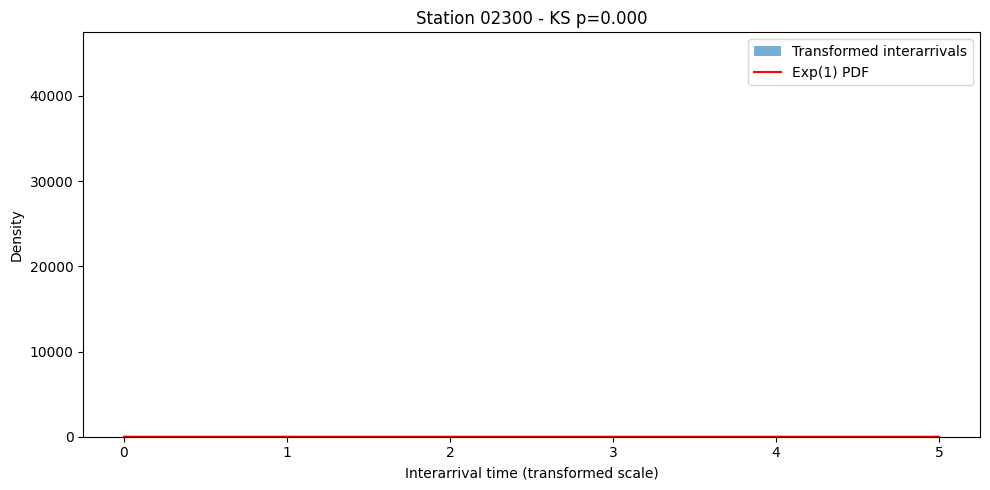

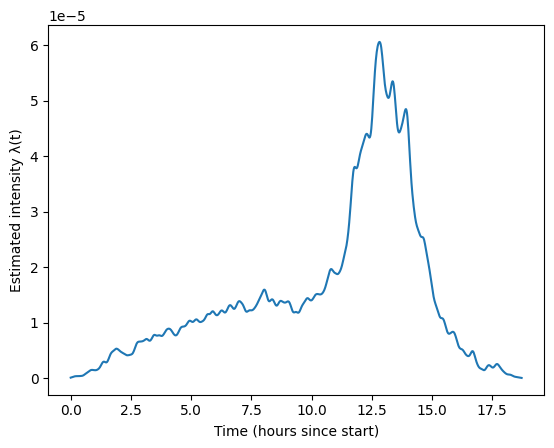

In [9]:
run_nhpp_test_kde("20251014", "02300")

In [5]:
def nhpp_test_piecewise(df_segment, window="5min"):
    """Run NHPP test for one time segment using piecewise-constant λ(t)."""
    if len(df_segment) < 30:
        return None, None, None

    df_segment = df_segment.sort_values("Fecha_Transaccion")
    t = (df_segment["Fecha_Transaccion"] - df_segment["Fecha_Transaccion"].min()).dt.total_seconds().values

    # 1. Bin into windows
    df_segment["window"] = df_segment["Fecha_Transaccion"].dt.floor(window)
    counts = df_segment.groupby("window").size().reset_index(name="count")
    counts["lambda"] = counts["count"] / pd.Timedelta(window).total_seconds()

    # 2. Build Λ(t) step function
    times = (counts["window"] - counts["window"].min()).dt.total_seconds().values
    lambdas = counts["lambda"].values

    # Compute cumulative Λ(t)
    dt = np.diff(times, append=times[-1] + pd.Timedelta(window).total_seconds())
    Lambda_t = np.cumsum(lambdas * dt)

    # Interpolate Λ for event times
    Lambda_interp = np.interp(t, times, Lambda_t)
    interarrivals = np.diff(Lambda_interp)

    # 3. KS test
    ks_stat, p_value = stats.kstest(interarrivals, 'expon', args=(0, 1))
    return ks_stat, p_value, interarrivals


def run_nhpp_test(file_code: str, station_code: str):
    """Run NHPP goodness-of-fit test for a given station and file (date code), using piecewise λ(t)."""
    folder_path = "../../../../data/check_ins/daily"
    file_path = os.path.join(folder_path, f"{file_code}.csv")

    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        sys.exit(1)

    print(f"📂 Loading data from {file_path}")
    df = pd.read_csv(
        file_path,
        usecols=["Fecha_Transaccion", "Estacion_Parada"],
        parse_dates=["Fecha_Transaccion"],
    )

    df["Fecha_Transaccion"] += pd.to_timedelta(
        np.random.uniform(0, 1, size=len(df)), unit="s"
    )

    # Extract station info and filter
    df["station_code"], df["station_name"] = zip(*df["Estacion_Parada"].apply(extract_station_info))
    df = df[df["station_code"] == station_code]

    if df.empty:
        print(f"⚠️ No data found for station code {station_code}")
        sys.exit(1)

    print(f"✅ Found {len(df)} check-ins for station {station_code}")

    # Hourly segmentation
    df["hour"] = df["Fecha_Transaccion"].dt.hour
    results = []

    for hour, seg_df in df.groupby("hour"):
        ks_stat, p_value, interarrivals = nhpp_test_piecewise(seg_df, window="5min")
        if ks_stat is None:
            continue
        results.append((hour, ks_stat, p_value))
        print(f"Hour {hour:02d}: KS={ks_stat:.4f}, p={p_value:.4f}")

    # Summary
    print("\n📊 Hourly NHPP Goodness-of-Fit Summary (piecewise λ)")
    summary = pd.DataFrame(results, columns=["hour", "KS_stat", "p_value"])
    print(summary)

    # Plot p-values
    plt.figure(figsize=(10, 5))
    plt.plot(summary["hour"], summary["p_value"], marker="o")
    plt.axhline(0.05, color="r", linestyle="--", label="Significance level (0.05)")
    plt.title(f"NHPP hourly p-values — Station {station_code} ({file_code}) [Piecewise λ]")
    plt.xlabel("Hour of Day")
    plt.ylabel("KS test p-value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return summary


📂 Loading data from ../../../../data/check_ins/daily\20251014.csv
✅ Found 41571 check-ins for station 02300
Hour 05: KS=0.1606, p=0.0000
Hour 06: KS=0.0834, p=0.0002
Hour 07: KS=0.0980, p=0.0000
Hour 08: KS=0.0820, p=0.0000
Hour 09: KS=0.0930, p=0.0000
Hour 10: KS=0.0846, p=0.0000
Hour 11: KS=0.0842, p=0.0000
Hour 12: KS=0.0866, p=0.0000
Hour 13: KS=0.0778, p=0.0000
Hour 14: KS=0.0834, p=0.0000
Hour 15: KS=0.0958, p=0.0000
Hour 16: KS=0.0926, p=0.0000
Hour 17: KS=0.0834, p=0.0000
Hour 18: KS=0.0545, p=0.0000
Hour 19: KS=0.0649, p=0.0000
Hour 20: KS=0.0810, p=0.0000
Hour 21: KS=0.1398, p=0.0000
Hour 22: KS=0.1592, p=0.0001

📊 Hourly NHPP Goodness-of-Fit Summary (piecewise λ)
    hour   KS_stat       p_value
0      5  0.160609  8.284091e-06
1      6  0.083397  1.953903e-04
2      7  0.097953  2.602297e-08
3      8  0.081977  1.439991e-07
4      9  0.093025  1.257854e-11
5     10  0.084572  3.550952e-11
6     11  0.084244  2.142301e-12
7     12  0.086572  3.251233e-14
8     13  0.077846  

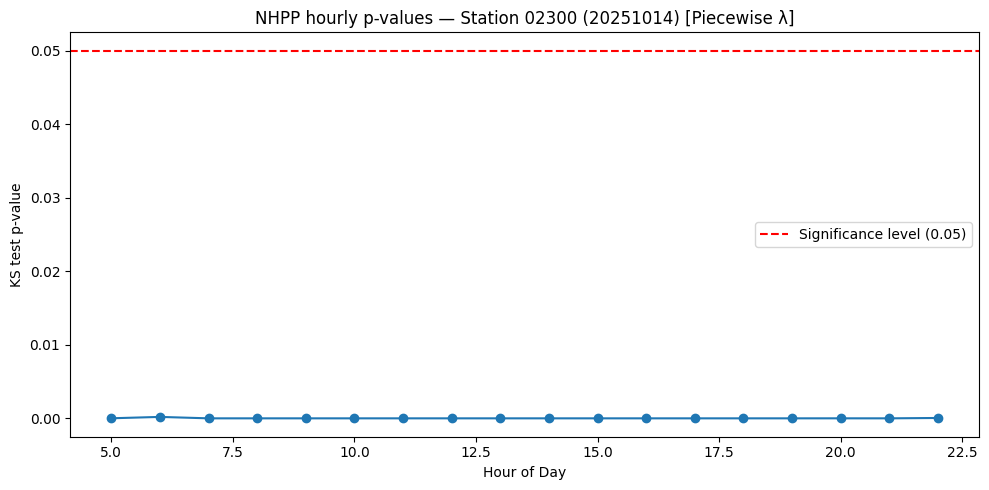

,hour,KS_stat,p_value
0,5,0.160609,8.284091e-06
1,6,0.083397,1.953903e-04
2,7,0.097953,2.602297e-08
3,8,0.081977,1.439991e-07
4,9,0.093025,1.257854e-11
5,10,0.084572,3.550952e-11
6,11,0.084244,2.142301e-12
7,12,0.086572,3.251233e-14
8,13,0.077846,9.445342e-11
9,14,0.083420,3.379511e-13


In [6]:
run_nhpp_test("20251014", "02300")

In [10]:
def collapse_to_batches(df, gap_s=5):
    """Collapse bursts of arrivals within 'gap_s' seconds into single events."""
    df = df.sort_values("Fecha_Transaccion").copy()
    dt = df["Fecha_Transaccion"].diff().dt.total_seconds().fillna(np.inf).values
    batch_id = (dt > gap_s).cumsum()
    grouped = df.groupby(batch_id)["Fecha_Transaccion"].first().reset_index(drop=True)
    return pd.DataFrame({"Fecha_Transaccion": grouped})

# ---------- Kim & Whitt Transformations ----------
def conditional_uniform_transform(df_segment, a, b):
    """Map arrival times T_j in [a,b] to U_j in [0,1]."""
    duration = (b - a).total_seconds()
    if duration <= 0 or df_segment.empty:
        return np.array([])
    t = (df_segment["Fecha_Transaccion"] - a).dt.total_seconds().to_numpy()
    return t / duration

def log_transform_from_interval(arrivals, a, b):
    """Brown et al. 'Log' transform producing Exp(1) samples."""
    if len(arrivals) < 1:
        return np.array([])
    t_total = (b - a).total_seconds()
    rel = (arrivals.sort_values() - a).dt.total_seconds().to_numpy()
    n = len(rel)
    T_prev = np.concatenate(([0.0], rel))
    T_curr = np.concatenate((rel, [t_total]))
    Xlog = np.zeros(n)
    for j in range(1, n + 1):
        num = t_total - T_curr[j - 1]
        den = t_total - T_prev[j - 1]
        ratio = max(num / den, 1e-12)
        Xlog[j - 1] = -(n + 1 - j) * np.log(ratio)
    return Xlog

def lewis_durbin_transform_from_interval(arrivals, a, b):
    """Lewis/Durbin transformation producing Uniform(0,1) samples."""
    if len(arrivals) < 1:
        return np.array([])
    t_total = (b - a).total_seconds()
    U = (arrivals.sort_values() - a).dt.total_seconds().to_numpy() / t_total
    U = np.clip(U, 0, 1)
    U.sort()
    n = len(U)
    C = np.empty(n + 1)
    C[0] = U[0]
    if n > 1:
        C[1:n] = U[1:] - U[:-1]
    C[n] = 1 - U[-1]
    C_sorted = np.sort(C)
    C_ext = np.concatenate(([0.0], C_sorted))
    Z = np.zeros(n + 1)
    for j in range(1, n + 2):
        Z[j - 1] = (n + 2 - j) * (C_ext[j] - C_ext[j - 1])
    S = np.cumsum(Z)[:n]
    return S

# ---------- KS Test helpers ----------
def ks_test_uniform(samples):
    if len(samples) < 10:
        return None, None
    stat, p = stats.kstest(samples, 'uniform', args=(0, 1))
    return stat, p

def ks_test_expon(samples):
    if len(samples) < 10:
        return None, None
    stat, p = stats.kstest(samples, 'expon', args=(0, 1))
    return stat, p

# ---------- NHPP test pipeline ----------
def nhpp_tests_for_segment(df_segment, window="5min"):
    """Run CU, Log, and Lewis transforms across all subwindows in df_segment."""
    if df_segment.empty:
        return None

    df_segment = df_segment.sort_values("Fecha_Transaccion").copy()
    df_segment["window"] = df_segment["Fecha_Transaccion"].dt.floor(window)

    all_cu, all_log, all_lewis = [], [], []
    for win_start, group in df_segment.groupby("window"):
        a = win_start
        b = a + pd.Timedelta(window)
        if len(group) < 2:
            continue
        all_cu.extend(conditional_uniform_transform(group, a, b))
        all_log.extend(log_transform_from_interval(group["Fecha_Transaccion"], a, b))
        all_lewis.extend(lewis_durbin_transform_from_interval(group["Fecha_Transaccion"], a, b))

    cu_stat, cu_p = ks_test_uniform(np.array(all_cu))
    log_stat, log_p = ks_test_expon(np.array(all_log))
    lewis_stat, lewis_p = ks_test_uniform(np.array(all_lewis))

    return {
        "CU_stat": cu_stat, "CU_p": cu_p,
        "LOG_stat": log_stat, "LOG_p": log_p,
        "LEWIS_stat": lewis_stat, "LEWIS_p": lewis_p,
        "n_events": len(df_segment)
    }

# ---------- Main ----------
def run_kim_whitt_tests(file_code, station_code, jitter_s=0, batch_gap_s=None):
    folder_path = "../../../../data/check_ins/daily"
    file_path = os.path.join(folder_path, f"{file_code}.csv")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        sys.exit(1)

    print(f"📂 Loading data from {file_path}")
    df = pd.read_csv(file_path, usecols=["Fecha_Transaccion", "Estacion_Parada"], parse_dates=["Fecha_Transaccion"])
    df["station_code"], df["station_name"] = zip(*df["Estacion_Parada"].apply(extract_station_info))
    df = df[df["station_code"] == station_code].copy()
    if df.empty:
        print(f"⚠️ No data found for station {station_code}")
        sys.exit(1)

    print(f"✅ Loaded {len(df)} check-ins for station {station_code}")

    # Optional jitter
    if jitter_s > 0:
        print(f"⏱️ Adding jitter up to {jitter_s} seconds...")
        df["Fecha_Transaccion"] += pd.to_timedelta(np.random.uniform(0, jitter_s, len(df)), unit="s")

    # Optional burst collapse
    if batch_gap_s is not None:
        print(f"🧩 Collapsing arrivals with ≤ {batch_gap_s}s gap...")
        df = collapse_to_batches(df, gap_s=batch_gap_s)
        print(f"✅ Reduced to {len(df)} batch events")

    df["hour"] = df["Fecha_Transaccion"].dt.hour
    results = []
    for hour, seg in df.groupby("hour"):
        res = nhpp_tests_for_segment(seg, window="5min")
        if not res:
            continue
        res["hour"] = hour
        results.append(res)
        try:
            print(f"Hour {hour:02d}: CU p={res['CU_p']:.4f}, LOG p={res['LOG_p']:.4f}, LEWIS p={res['LEWIS_p']:.4f}")
        except Exception:
            continue

    results_df = pd.DataFrame(results)
    print("\n📊 Summary (p-values):")
    print(results_df[["hour", "CU_p", "LOG_p", "LEWIS_p"]])

    plt.figure(figsize=(10,5))
    plt.plot(results_df["hour"], results_df["CU_p"], marker="o", label="CU")
    plt.plot(results_df["hour"], results_df["LOG_p"], marker="s", label="Log")
    plt.plot(results_df["hour"], results_df["LEWIS_p"], marker="^", label="Lewis")
    plt.axhline(0.05, color="r", linestyle="--", label="Significance 0.05")
    plt.title(f"Kim & Whitt NHPP tests — Station {station_code} ({file_code})")
    plt.xlabel("Hour of day")
    plt.ylabel("p-value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

📂 Loading data from ../../../../data/check_ins/daily\20251014.csv
✅ Loaded 18216 check-ins for station 07107
⏱️ Adding jitter up to 1 seconds...
Hour 04: CU p=0.0496, LOG p=0.0534, LEWIS p=0.0675
Hour 05: CU p=0.1402, LOG p=0.6420, LEWIS p=0.2542
Hour 06: CU p=0.1431, LOG p=0.3902, LEWIS p=0.0095
Hour 07: CU p=0.8556, LOG p=0.2116, LEWIS p=0.1289
Hour 08: CU p=0.9318, LOG p=0.0299, LEWIS p=0.0265
Hour 09: CU p=0.5813, LOG p=0.3748, LEWIS p=0.1029
Hour 10: CU p=0.3725, LOG p=0.5391, LEWIS p=0.4138
Hour 11: CU p=0.3943, LOG p=0.2330, LEWIS p=0.2821
Hour 12: CU p=0.1266, LOG p=0.0585, LEWIS p=0.0012
Hour 13: CU p=0.0057, LOG p=0.0004, LEWIS p=0.0002
Hour 14: CU p=0.4308, LOG p=0.0966, LEWIS p=0.0238
Hour 15: CU p=0.0324, LOG p=0.0019, LEWIS p=0.0042
Hour 16: CU p=0.6006, LOG p=0.0000, LEWIS p=0.0000
Hour 17: CU p=0.3007, LOG p=0.0001, LEWIS p=0.0000
Hour 18: CU p=0.9225, LOG p=0.0000, LEWIS p=0.0000
Hour 19: CU p=0.5026, LOG p=0.1369, LEWIS p=0.0356
Hour 20: CU p=0.0902, LOG p=0.0276, LEW

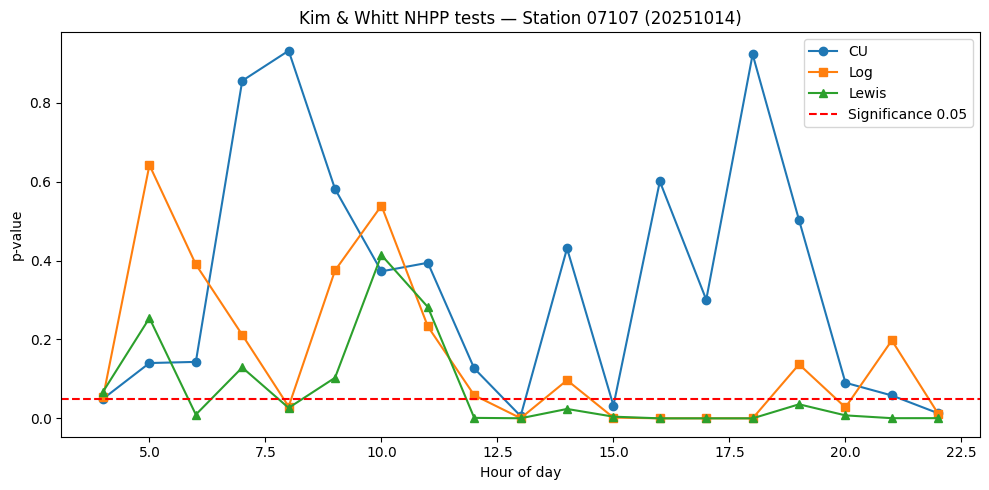

,CU_stat,CU_p,LOG_stat,LOG_p,LEWIS_stat,LEWIS_p,n_events,hour
0,0.375852,0.049587,0.372092,5.337174e-02,0.359796,6.750881e-02,14,4
1,0.106022,0.140177,0.067729,6.419786e-01,0.093218,2.541884e-01,115,5
2,0.069132,0.143089,0.054178,3.901798e-01,0.098716,9.450267e-03,271,6
3,0.033147,0.855572,0.058256,2.116096e-01,0.064427,1.288866e-01,325,7
4,0.029194,0.931816,0.079043,2.986309e-02,0.080153,2.652926e-02,332,8
5,0.035362,0.581311,0.041596,3.747832e-01,0.055584,1.029348e-01,474,9
6,0.043938,0.372550,0.038527,5.390637e-01,0.042492,4.137880e-01,426,10
7,0.031691,0.394326,0.036573,2.329566e-01,0.034886,2.820861e-01,794,11
8,0.036231,0.126550,0.041000,5.854297e-02,0.059556,1.179476e-03,1042,12
9,0.047882,0.005718,0.057801,3.951166e-04,0.060277,1.875354e-04,1270,13


In [11]:
run_kim_whitt_tests("20251014", "07107", 1)